# Springboard Capstone 3: Customer Segmentation

This project will use UCI's Online Retail II data for unsupervised clustering techniques to determine appropriate segments.

See http://archive.ics.uci.edu/ml/datasets/Online+Retail+II for dataset description and more info.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime
from dython import nominal
from pandas.plotting import scatter_matrix

In [2]:
# Read in our .xlsx file
xls = pd.read_excel('online_retail_II.xlsx', sheet_name=[0,1])
xls[0].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
raw_df = pd.concat([xls[0], xls[1]], ignore_index=True)
raw_df.shape

(1067371, 8)

In [4]:
# Remove space from Customer ID column name for ease and consistency
raw_df = raw_df.rename(columns={'Customer ID': 'CustomerID'})
raw_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Look for null values and dtypes
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [6]:
# Calculate percentage of null values
print("Percent Null Description:",raw_df.Description.isnull().sum() / len(raw_df) * 100)
print("Percent Null CustomerID:",raw_df.CustomerID.isnull().sum() / len(raw_df) * 100)

Percent Null Description: 0.4105414143723223
Percent Null CustomerID: 22.766872999172733


In [7]:
# Check our numerical values
raw_df.describe()

,Quantity,Price,CustomerID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


## Data Cleaning

Let's take the time to closely examine the records in our dataset as we clean it, and see if any new questions or problems arise.

Before reviewing null values as a whole, we can start tackling them by looking for anomalous records based on price and quantity. In other words, we're looking for records that are not actually customer transactions, some of which will be have a null customer ID anyway, and some of which won't.

We can judge whether records should be dropped based on the Description/Stock Code.

In [8]:
# First, the records with a negative Price value.
neg_price = raw_df[raw_df.Price<0]
neg_price

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


These look like adjustments made by the company. Thus they are not customer transactions and should be removed.

In [9]:
df = raw_df.drop(neg_price.index)
df.shape

(1067366, 8)

In [10]:
# Next we'll look at records with a price of 0.
no_price = df[df.Price==0]
no_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6202 entries, 263 to 1064386
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      6202 non-null   object        
 1   StockCode    6202 non-null   object        
 2   Description  1820 non-null   object        
 3   Quantity     6202 non-null   int64         
 4   InvoiceDate  6202 non-null   datetime64[ns]
 5   Price        6202 non-null   float64       
 6   CustomerID   71 non-null     float64       
 7   Country      6202 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 436.1+ KB


Only 71 of 6202 records have Customer IDs. Perhaps these were promotional gifts, etc. The null records could be inventory adjustments, test records, or mistakes. They should all be removed.

In [11]:
df = df.drop(no_price.index)
df.shape

(1061164, 8)

In [12]:
# Next, we'll go to the other end of the Price range, suspiciously high prices.
by_price = df.sort_values('Price', ascending=False)
by_price.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,NaN,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,NaN,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,NaN,United Kingdom
569163,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,NaN,United Kingdom
569164,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,NaN,United Kingdom
540477,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
540478,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom


In [13]:
# There are several records with prices above 10,000. What kind of records have such high prices?
df.groupby(['Description', 'StockCode']).max(numeric_only=True).Price.sort_values(ascending=False).head(15)

Description                          StockCode   
Manual                               M               38970.00
Bank Charges                         BANK CHARGES    18910.69
AMAZON FEE                           AMAZONFEE       17836.46
Adjust bad debt                      B               11062.06
POSTAGE                              POST             8142.75
Adjustment by john on 26/01/2010 17  ADJUST           5117.03
DOTCOM POSTAGE                       DOT              4505.17
Discount                             D                1867.86
FLAG OF ST GEORGE CAR FLAG           84016            1157.15
CRUK Commission                      CRUK             1100.44
 Bank Charges                        BANK CHARGES      848.43
PICNIC BASKET WICKER 60 PIECES       22502             649.50
SAMPLES                              S                 605.18
Adjustment by Peter on Jun 25 2010   ADJUST2           358.47
Adjustment by Peter on 24/05/2010 1  ADJUST            358.47
Name: Price, dtype: 

In [14]:
# Looks like we might want to inspect ALL stock codes that start with a letter, as these are special kinds of transactions
# (This will help us identify irrelevant transactions, even at lower prices)
alpha_codes = df[df.StockCode.str[0].str.isalpha()==True]
alpha_codes = alpha_codes.groupby(['StockCode', 'Description']).count()[['Invoice', 'CustomerID']]
alpha_codes.sort_index()

Invoice  CustomerID
StockCode    Description                                             
ADJUST       Adjustment by Peter on 24/05/2010 1        3           3
             Adjustment by john on 26/01/2010 16       38          36
             Adjustment by john on 26/01/2010 17       26          22
ADJUST2      Adjustment by Peter on Jun 25 2010         3           3
AMAZONFEE    AMAZON FEE                                43           0
B            Adjust bad debt                            1           0
BANK CHARGES  Bank Charges                              6           3
             Bank Charges                              96          35
C2           CARRIAGE                                 279         259
CRUK         CRUK Commission                           16          16
D            Discount                                 177         174
DCGS0003     BOXED GLASS ASHTRAY                       13           0
DCGS0004     HAYNES CAMPER SHOULDER BAG                 4           0
DCGS0037     KEY-RING CORKSCREW                         1           0
DCGS0041     HAYNES MINI-COOPER PLAYING CARDS           1           0
DCGS0044     HANDZ-OFF CAR FRESHENER                    1           0
DCGS0058     MISO PRETTY  GUM                          30           0
DCGS0062     ROAD-RAGE CAR FRESHENER                    1           0
DCGS0066N    NAVY CUDDLES DOG HOODIE                    2           0
DCGS0068     DOGS NIGHT COLLAR                          2           0
DCGS0069     OOH LA LA DOGS COLLAR                      5           0
DCGS0070     CAMOUFLAGE DOG COLLAR                      2           0
DCGS0072     CAT CAMOUFLAGUE COLLAR                     3           0
DCGS0075     CAMOUFLAGUE DOG LEAD                       1           0
DCGS0076     SUNJAR LED NIGHT NIGHT LIGHT              15           0
DCGSSBOY     BOYS PARTY BAG                            21           0
DCGSSGIRL    GIRLS PARTY BAG                           23           0
DOT          DOTCOM POSTAGE                          1439          16
M            Manual                                  1414        1108
PADS         PADS TO MATCH ALL CUSHIONS                18          18
POST         POSTAGE                                 2115        2019
S            SAMPLES                                  104           0
SP1002       KID'S CHALKBOARD/EASEL                     2           2
TEST001      This is a test product.                   13          13
TEST002      This is a test product.                    1           1
gift_0001_10 Dotcomgiftshop Gift Voucher £10.00        14           0
gift_0001_20 Dotcomgiftshop Gift Voucher £20.00        26           0
gift_0001_30 Dotcomgiftshop Gift Voucher £30.00        24           0
gift_0001_40 Dotcomgiftshop Gift Voucher £40.00         5           0
gift_0001_50 Dotcomgiftshop Gift Voucher £50.00         6           0
gift_0001_70 Dotcomgiftshop Gift Voucher £70.00         1           0
gift_0001_80 Dotcomgiftshop Gift Voucher £80.00         2           0
m            Manual                                     5           0

Here we've learned most of the biggest amounts aren't actual transactions, but manual adjustments and fees. Choosing which to keep and which to remove could be subjective, so I'll list my reasoning here.

First, It's probably best to remove all Bank Charges, Amazon Fees, and Postage/Carriage. Although these fees are certainly worth considering for revenue/cost analysis, whatever insight they give us on customer behavior and value is beyond this project.

Samples also aren't relevant here, so they should be discarded as well. Commissions and 'Adjust bad debt' are not related to customers, and should also be discarded

Discounts, however, can be maintained as they are relevant to a customer's monetary value.

That leaves "Manual" records. A careful look at the top price records shows these manual entries *must* be related (For example, the two transactions with price 25111.09. Further examination not saved in this workbook showed many 'Manual' charges and corresponding cancellations for the same exact amount on the same day), yet some have Customer IDs and some don't. The mismatched cancellations could really skew the data on monetary value of individual customers, especially considering the high prices. 

For the purposes of this project, it is not worth it to fill in any missing Customer IDs. Out of an abundance of caution, we should delete all the manual entries as well, even though we will lose some legitimate transactions. Hopefully, these discrepancies are limited to the manual records.

The 'Adjustment by..." records actually seem to be more reliable, with fewer null IDs and no clear matching cancellations ***(see below)***, so we can keep these in our df to more accurately judge customer value.

Other codes on this list look like legitimate transactions, though most will be removed along with other null CustomerID records.

In [15]:
# Signed adjustment records sorted by price (to identify possibly null ID records with matching cancellations)
# Notice the records with NaN Customer ID do not match any other records in price, as we saw with the Manual label.
df[df.StockCode=='ADJUST'].sort_values('Price').tail(16)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
71033,495747,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,129.23,12555.0,Spain
71035,495752,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:28:00,130.56,NaN,EIRE
71034,495750,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:27:00,132.79,14156.0,EIRE
71064,495782,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:10:00,139.71,14156.0,EIRE
71039,495753,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,178.31,14653.0,United Kingdom
71059,495777,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:05:00,179.45,14156.0,EIRE
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,12745.0,EIRE
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,14911.0,EIRE
71071,495791,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:19:00,243.63,14079.0,United Kingdom
71042,495758,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:30:00,274.20,14911.0,EIRE


In [16]:
# Get indices of descriptions we want to remove, and drop them from the df
remove_codes = ['AMAZONFEE', 'B', 'BANK CHARGES', 'C2', 'CRUK', 'DOT', 'M', 'POST', 'S', 'TEST001', 'TEST002', 'm']
to_remove = df[df.StockCode.isin(remove_codes)==True]
df = df.drop(to_remove.index)
df.shape

(1055632, 8)

Next up, we'll take a look at the Quantity column. All cancellations are marked with a C in the invoice and have a negative quantity. We've already taken care of any records with a negative Quantity that were *not* cancellations along with the other $0.00 transactions.

Ideally, we want to keep cancellations in our data, but should be wary if we see any cancellations that do not have a corresponding sale labeled with the same Customer ID (this is why we discarded the Manual data).

As an example, let's look at the customer with the largest quantity of cancelled items and make sure the records match up.

In [17]:
# Filter only records with invoice starting with C
cax = df[df.Invoice.str.contains('C')==True]

# Find IDs with largest quantity of cancellations
cax.groupby('CustomerID').sum().Quantity.sort_values().head()

CustomerID
14277.0   -87919
16446.0   -80995
12346.0   -74217
15838.0   -18840
12931.0   -14261
Name: Quantity, dtype: int64

In [18]:
# Inspect the top customer ID
df[df.CustomerID==14277].sort_values('Price').head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
359659,C524235,16053,POPART COL BALLPOINT PEN ASST,-2000,2010-09-28 11:02:00,0.03,14277.0,France
298952,518505,16053,POPART COL BALLPOINT PEN ASST,2000,2010-08-09 13:10:00,0.03,14277.0,France
359660,C524235,16162L,THE KING GIFT BAG,-3744,2010-09-28 11:02:00,0.05,14277.0,France
298951,518505,16162L,THE KING GIFT BAG,3744,2010-08-09 13:10:00,0.05,14277.0,France
298956,518505,10123G,ARMY CAMO WRAPPING TAPE,1104,2010-08-09 13:10:00,0.06,14277.0,France
359657,C524235,16043,POP ART PUSH DOWN RUBBER,-960,2010-09-28 11:02:00,0.06,14277.0,France
359656,C524235,10123G,ARMY CAMO WRAPPING TAPE,-1104,2010-09-28 11:02:00,0.06,14277.0,France
359655,C524235,10123C,HEARTS WRAPPING TAPE,-144,2010-09-28 11:02:00,0.06,14277.0,France
298957,518505,10123C,HEARTS WRAPPING TAPE,144,2010-08-09 13:10:00,0.06,14277.0,France
298955,518505,16043,POP ART PUSH DOWN RUBBER,960,2010-08-09 13:10:00,0.06,14277.0,France


Looks like this record checks out, this customer happens to have a huge quantity of cancelled orders, each with a corresponding initial order. We can confidently move on to any remaining null records.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055632 entries, 0 to 1067369
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1055632 non-null  object        
 1   StockCode    1055632 non-null  object        
 2   Description  1055632 non-null  object        
 3   Quantity     1055632 non-null  int64         
 4   InvoiceDate  1055632 non-null  datetime64[ns]
 5   Price        1055632 non-null  float64       
 6   CustomerID   820823 non-null   float64       
 7   Country      1055632 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 72.5+ MB


In [20]:
# Calculate percentage of null values
print("Records missing Customer ID: ",df.CustomerID.isnull().sum(),
      "\n\nPercent Null:",df.CustomerID.isnull().sum() / len(df) * 100)

Records missing Customer ID:  234809 

Percent Null: 22.243452263667642


We've rooted out all of the records missing a Description, but barely put a dent in records missing IDs!

Obviously, the Customer ID is essential information in order to assess customer behavior. Unfortunately, we will have to take out all records that don't include that information.

However, before we take these records out of the dataset, it's worth considering why these records are missing information, and whether they have any special characteristics. 

If this field is null due to some random error (say, accidental deletion of the data), then perhaps we can safely ignore them. But if, for instance, these purchases don't have IDs because they were made as a 'Guest' at checkout, the information here may tell us something about a different segment of customers (those who do not want to create an account). Let's take a quick closer look at these records and how they compare with the rest of the data.

In [21]:
# Another check for descriptions indicating false transactions - 20 most common descriptions with null IDs
df[df.CustomerID.isnull()==True].Description.value_counts().head(20)

JUMBO BAG RED RETROSPOT               689
REGENCY CAKESTAND 3 TIER              633
JUMBO STORAGE BAG SUKI                633
PARTY BUNTING                         620
WHITE HANGING HEART T-LIGHT HOLDER    598
RECYCLING BAG RETROSPOT               573
JUMBO SHOPPER VINTAGE RED PAISLEY     528
WOODLAND CHARLOTTE BAG                523
JUMBO BAG WOODLAND ANIMALS            509
STRAWBERRY CERAMIC TRINKET BOX        505
RED TOADSTOOL LED NIGHT LIGHT         505
SUKI  SHOULDER BAG                    488
CHARLOTTE BAG SUKI DESIGN             461
JUMBO  BAG BAROQUE BLACK WHITE        444
SMALL HEART MEASURING SPOONS          435
PACK OF 60 PINK PAISLEY CAKE CASES    434
LOVEBIRD HANGING DECORATION WHITE     432
NATURAL SLATE HEART CHALKBOARD        426
BATHROOM METAL SIGN                   424
GREEN REGENCY TEACUP AND SAUCER       423
Name: Description, dtype: int64

These descriptions seem to be legitimate sale items, not labels for other kinds of transactions.

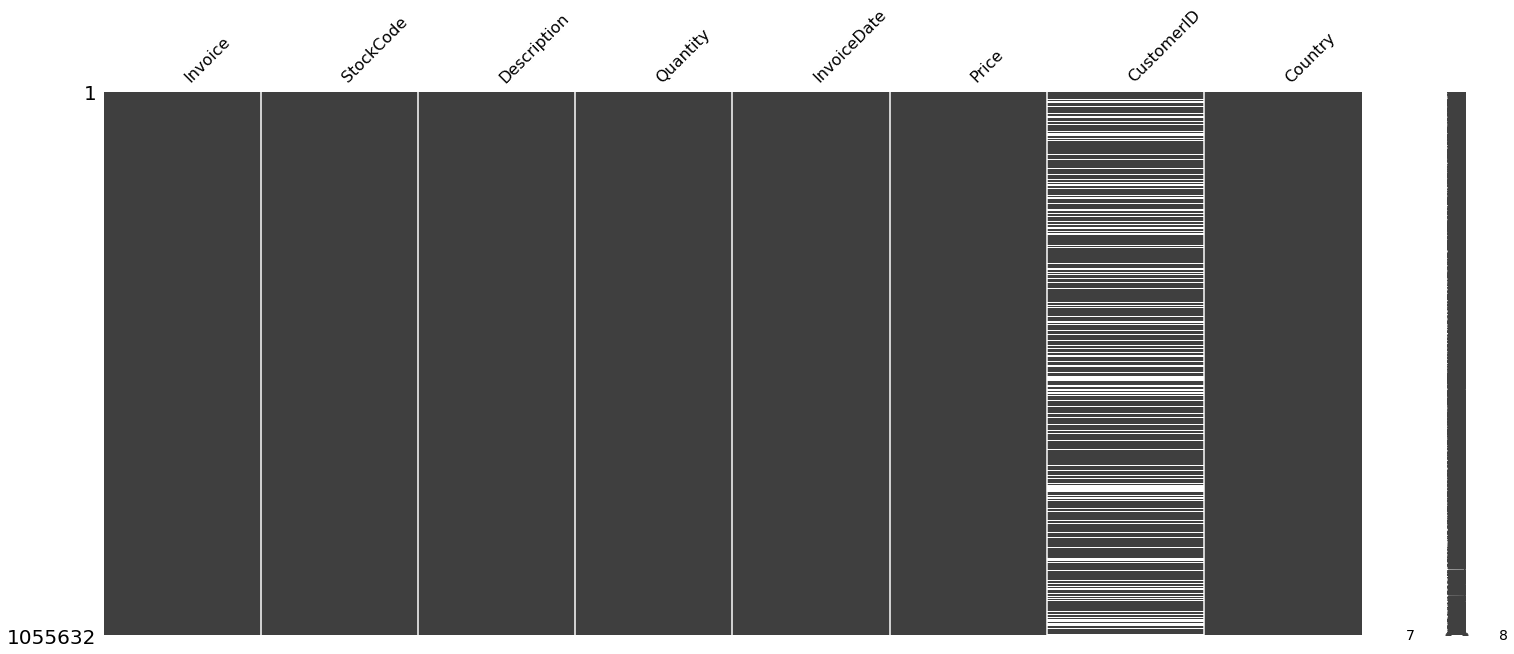

In [22]:
# See distribution of null values, looking for areas of concentration as possible signs of errors in data collection
msno.matrix(df);

There are null records throughout the data, but some thick bands of records that might indicate an error in the data collection (such as 'the Customer ID wasn't being tracked for this 6-hour period'). For the sake of thoroughness, we can check if there were any days with an especially high number of transactions missing IDs.

In [23]:
# Set datetime index to columns of interest
by_date = df.set_index(df.InvoiceDate)

# Add columns for date, and boolean of null or not null
by_date['date'] = by_date.index.date
by_date['null_id'] = by_date['CustomerID'].isnull()

# Aggregate total count and total null per date
null_by_date = by_date.groupby('date').agg({'null_id':['sum', 'count']})

# Calculate percentage of transactions per day that are null
null_by_date['pct'] = null_by_date['null_id']['sum'] / null_by_date['null_id']['count'] * 100

# Print findings
print("Percent null ID per day: \n", 
          null_by_date.pct.describe()[[1,3, 5,7]])
print("\nDays with greatest % null ID:\n", 
          null_by_date.sort_values('pct', ascending=False).pct.head())

Percent null ID per day: 
 mean    19.676839
min      0.000000
50%     17.724777
max     87.492222
Name: pct, dtype: float64

Days with greatest % null ID:
 date
2011-08-30    87.492222
2009-12-22    81.995776
2010-01-11    79.782037
2010-12-17    76.818623
2010-12-21    73.555841
Name: pct, dtype: float64


Although the average number of transactions per day with null Customer ID roughly matches the overall averages in the data (indicating mostly even distribution across all days), there are some days with alarmingly high numbers of null values, including Aug. 08, 2011 at ober 87%. Further investigation might be made into what happened on that date and others on the list.

In [24]:
# df of only null ID records
no_id = df[df.CustomerID.isnull()==True]
no_id.describe()

,Quantity,Price,CustomerID
count,234809.000000,234809.000000,0.0
mean,3.017393,4.769261,NaN
std,12.186933,12.112665,NaN
min,-144.000000,0.060000,NaN
25%,1.000000,1.660000,NaN
50%,1.000000,3.360000,NaN
75%,2.000000,5.790000,NaN
max,1820.000000,5117.030000,NaN


In [25]:
#df of only non-null ID records
no_null = df[df.CustomerID.isnull()==False]
no_null.describe()

,Quantity,Price,CustomerID
count,820823.000000,820823.000000,820823.000000
mean,12.438107,2.988935,15331.119104
std,188.847168,5.548779,1694.570044
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13982.000000
50%,5.000000,1.950000,15270.000000
75%,12.000000,3.750000,16799.000000
max,80995.000000,1867.860000,18287.000000


In [26]:
# Cap price at $500 to limit extreme outliers
no_id_lower = no_id[no_id.Price < 500]
no_null_lower = no_null[no_null.Price < 500]

print(no_id_lower.describe())
no_null_lower.describe()

            Quantity          Price  CustomerID
count  234805.000000  234805.000000         0.0
mean        3.017436       4.736782         NaN
std        12.187032       5.052313         NaN
min      -144.000000       0.060000         NaN
25%         1.000000       1.660000         NaN
50%         1.000000       3.360000         NaN
75%         2.000000       5.790000         NaN
max      1820.000000     408.400000         NaN


,Quantity,Price,CustomerID
count,820816.000000,820816.000000,820816.000000
mean,12.438144,2.980926,15331.115263
std,188.847962,4.648450,1694.571290
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13982.000000
50%,5.000000,1.950000,15270.000000
75%,12.000000,3.750000,16799.000000
max,80995.000000,434.510000,18287.000000


In [27]:
# Cap Quantity at 1000 to limit extreme outliers
no_id_lower = no_id[no_id.Quantity < 1000]
no_null_lower = no_null[no_null.Quantity < 1000]

print(no_id_lower.describe())
no_null_lower.describe()

            Quantity          Price  CustomerID
count  234803.000000  234803.000000         0.0
mean        2.983782       4.769349         NaN
std        10.122892      12.112806         NaN
min      -144.000000       0.060000         NaN
25%         1.000000       1.660000         NaN
50%         1.000000       3.360000         NaN
75%         2.000000       5.790000         NaN
max       902.000000    5117.030000         NaN


,Quantity,Price,CustomerID
count,820498.000000,820498.000000,820498.000000
mean,11.270608,2.989891,15331.144184
std,128.224885,5.549652,1694.536299
min,-80995.000000,0.001000,12346.000000
25%,2.000000,1.250000,13982.000000
50%,5.000000,1.950000,15270.000000
75%,12.000000,3.750000,16799.000000
max,992.000000,1867.860000,18287.000000


In [28]:
# Look for countries that appear ONLY in null ID records
no_id_countries = no_id.Country.unique()
no_null_countries = no_null.Country.unique()
np.setdiff1d(no_id_countries, no_null_countries)

array(['Bermuda', 'Hong Kong'], dtype=object)

In [29]:
# Check number of combined invoices for those countries
df[(df.Country=='Bermuda')|(df.Country=='Hong Kong')].groupby(['Country', 'Invoice']).count()

StockCode  Description  Quantity  InvoiceDate  Price  \
Country   Invoice                                                         
Bermuda   501577          34           34        34           34     34   
Hong Kong 505214          48           48        48           48     48   
          513405          24           24        24           24     24   
          541975          57           57        57           57     57   
          549738          32           32        32           32     32   
          553148          93           93        93           93     93   
          557675          15           15        15           15     15   
          564087          48           48        48           48     48   
          571652          27           27        27           27     27   
          573154           7            7         7            7      7   
          C569495          1            1         1            1      1   

                   CustomerID  
Country   Invoice              
Bermuda   501577            0  
Hong Kong 505214            0  
          513405            0  
          541975            0  
          549738            0  
          553148            0  
          557675            0  
          564087            0  
          571652            0  
          573154            0  
          C569495           0

The records missing IDs have a higher average price (\~\\$5 vs. \~\\$3) and lower average quantity (~3 vs. ~13) than the other records, even after ignoring transactions with a price greater than $500 or quantity greater than 1000.

All records from Bermuda and Hong Kong had null IDs (It's worth checking if there is some reason Hong Kong customers aren't being recorded, since there are many).

Further analysis should be considered on this group of null IDs, if it is possible to determine the reason(s) for the missing information, as there does seem to be a difference in behavior among this group.

Moving on, let's keep only non-null records and begin visualizing some patterns in the data.

In [30]:
# Set df equal to only non-null records
df = no_null.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820823 entries, 0 to 820822
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      820823 non-null  object        
 1   StockCode    820823 non-null  object        
 2   Description  820823 non-null  object        
 3   Quantity     820823 non-null  int64         
 4   InvoiceDate  820823 non-null  datetime64[ns]
 5   Price        820823 non-null  float64       
 6   CustomerID   820823 non-null  float64       
 7   Country      820823 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 50.1+ MB


In [31]:
# Check some general info about our final dataset
print(df.InvoiceDate.min(), df.InvoiceDate.max(), df.Invoice.nunique(), df.CustomerID.nunique(), df.Country.nunique())

2009-12-01 07:45:00 2011-12-09 12:50:00 44084 5894 41


Our clean dataset contains information on transactions from Dec 01, 2009 to Dec 09, 2011, including over 44,000 unique orders from 5,894 unique customers across 41 different countries.

## Preprocessing + EDA

Using our transaction information for each customer, what features can we engineer to identify meaningful customer segments?

We can calculate RFM (recency, frequency, monetary value) for each customer over the period covered in the dataset, as well as other summary characteristics that might possibly tell us something about customer behavior. Although we may not end up using all of these features to train our model, they could be useful when we examine and define the resulting segments.

In [32]:
# First, calculate the value of each transaction by multiplying Quantity by Price
df['Value'] = df.Quantity * df.Price
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Value
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [33]:
# We'll condense our df into total orders, combining product transactions with the same invoice number
orders = df.groupby('Invoice').agg({'CustomerID':'min',
                                    'Country':'min',
                                    'InvoiceDate':'min',
                                    'Description':'count',
                                    'Quantity':'sum',
                                    'Price':['median', 'max'],
                                    'Value':'sum'
                                   })

# Rename the columns and reset index to retain Invoice number as a separate column
orders.columns = orders.columns.droplevel(1)
orders.columns = ['CustomerID', 'Country', 'Datetime', 'ItemCount', 'Quantity', 'Med_Price', 'Max_Price', 'Value']
orders.reset_index(inplace=True)
orders.head()

,Invoice,CustomerID,Country,Datetime,ItemCount,Quantity,Med_Price,Max_Price,Value
0,489434,13085.0,United Kingdom,2009-12-01 07:45:00,8,166,4.025,6.95,505.30
1,489435,13085.0,United Kingdom,2009-12-01 07:46:00,4,60,2.550,3.75,145.80
2,489436,13078.0,United Kingdom,2009-12-01 09:06:00,19,193,3.390,8.50,630.33
3,489437,15362.0,United Kingdom,2009-12-01 09:08:00,23,145,2.950,9.95,310.75
4,489438,18102.0,United Kingdom,2009-12-01 09:24:00,17,826,2.400,6.40,2286.24


In [34]:
# Now group by CustomerID with details for each customer that we will use for modeling
customers = orders.groupby('CustomerID').agg({'Country':'min',
                                              'Invoice':'count',
                                              'Datetime':'max',
                                              'ItemCount':'mean',
                                              'Max_Price':'max',
                                              'Value':['mean', 'sum']
                                              })

# Rename the columns
customers.columns = customers.columns.droplevel(1)
customers.columns = ['country', 'orders', 'last_order', 'avg_items',
                     'max_price', 'mean_value', 'total_value']
customers.describe()

,orders,avg_items,max_price,mean_value,total_value
count,5894.000000,5894.000000,5894.000000,5894.000000,5894.000000
mean,7.479471,19.893067,19.637799,310.936089,2834.094687
std,15.553202,18.388372,46.608723,409.404588,14056.847910
min,1.000000,1.000000,0.170000,-658.630000,-1343.240000
25%,2.000000,8.500000,8.500000,152.768750,329.460000
50%,4.000000,15.000000,12.750000,233.820714,850.140000
75%,8.000000,25.000000,16.950000,358.386250,2205.252500
max,471.000000,299.705882,1867.860000,11880.840000,605014.830000


Before anything else, we should take note of customers with a total value of 0 or less. Zero value customers (who cancelled everything they ordered) are not helpful to us, and we can take them out of our dataset. The negative value customers could be the result of errors in the data, or in some cases customers who returned old orders made before the data was recorded. They should also be removed to avoid contaminating our model.

In [35]:
# Find customers with <0 value (here we use <0.01 to make sure to capture floating point calculations)
no_value = customers[customers.total_value < 0.01]
no_value.sort_values('total_value')

,country,orders,last_order,avg_items,max_price,mean_value,total_value
CustomerID,,,,,,,
13091.0,United Kingdom,5,2011-11-18 16:48:00,24.200000,5.95,-2.686480e+02,-1.343240e+03
14213.0,United Kingdom,2,2010-12-03 09:47:00,7.500000,7.65,-5.961000e+02,-1.192200e+03
14337.0,United Kingdom,1,2009-12-08 14:04:00,36.000000,5.95,-6.586300e+02,-6.586300e+02
16252.0,United Kingdom,2,2010-12-08 16:15:00,31.500000,9.95,-1.475450e+02,-2.950900e+02
15767.0,United Kingdom,2,2010-03-08 15:48:00,4.500000,12.75,-1.213500e+02,-2.427000e+02
15935.0,United Kingdom,2,2011-04-14 13:27:00,16.500000,9.95,-1.003900e+02,-2.007800e+02
12706.0,Finland,1,2010-01-26 16:25:00,1.000000,91.89,-9.189000e+01,-9.189000e+01
17755.0,United Kingdom,1,2010-10-11 15:45:00,9.000000,9.95,-7.123000e+01,-7.123000e+01
16853.0,United Kingdom,1,2009-12-08 17:32:00,2.000000,6.75,-6.750000e+01,-6.750000e+01


In [36]:
# Drop all these customers from customers df
customers.drop(no_value.index, inplace=True)

#Drop from orders df as well
bad_orders = orders[orders.CustomerID.isin(no_value.index)==True]
orders = orders.drop(bad_orders.index).reset_index(drop=True)

#check customers
customers.describe()

,orders,avg_items,max_price,mean_value,total_value
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,7.533813,20.008880,19.723766,314.207950,2860.612116
std,15.612953,18.375504,46.795377,409.638874,14117.698480
min,1.000000,1.000000,0.170000,0.966667,2.900000
25%,2.000000,8.666667,8.500000,155.370000,337.490000
50%,4.000000,15.000000,12.750000,234.997778,865.170000
75%,8.000000,25.000000,16.950000,359.139167,2231.890000
max,471.000000,299.705882,1867.860000,11880.840000,605014.830000


That settled, we can now add more features to our data. We already have a representation of customer Frequency ('orders') and Monetary Value ('total_value'). We still need a Recency column, calculated from the day after the last day represented in the data, 2011-12-10.

In [37]:
# Set reference date
today = datetime.date(2011, 12, 10)

# Extract date from final_order column, calculate time delta, and reformat as an integer
customers['recency'] = (today - customers.last_order.dt.date)
customers['recency'] = customers.apply(lambda row: row.recency.days, axis=1)

In [38]:
# We can now delete the last_order column, since this information is better represented by the recency feature.
customers.drop(columns='last_order', inplace=True)

# Range of recency column should be 1 to 739, the min and max number of days from reference date in the dataset.
customers.describe()

,orders,avg_items,max_price,mean_value,total_value,recency
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,7.533813,20.008880,19.723766,314.207950,2860.612116,198.707242
std,15.612953,18.375504,46.795377,409.638874,14117.698480,208.348960
min,1.000000,1.000000,0.170000,0.966667,2.900000,1.000000
25%,2.000000,8.666667,8.500000,155.370000,337.490000,25.000000
50%,4.000000,15.000000,12.750000,234.997778,865.170000,93.000000
75%,8.000000,25.000000,16.950000,359.139167,2231.890000,377.000000
max,471.000000,299.705882,1867.860000,11880.840000,605014.830000,739.000000


Finally, it may be useful to have the average time between orders for repeat customers. We should ignore cancellations for this calculation.

In [39]:
# Remove cancellations from orders dataframe
no_cax = orders[orders.Invoice.str[0] != 'C']
times = no_cax.groupby(['CustomerID', 'Invoice']).max()
times.head()

Country            Datetime  ItemCount  Quantity  \
CustomerID Invoice                                                            
12346.0    499763   United Kingdom 2010-03-02 13:08:00          5         5   
           513774   United Kingdom 2010-06-28 13:53:00         19        19   
           541431   United Kingdom 2011-01-18 10:01:00          1     74215   
12347.0    529924          Iceland 2010-10-31 14:20:00         40       509   
           537626          Iceland 2010-12-07 14:57:00         62       638   

                    Med_Price  Max_Price     Value  
CustomerID Invoice                                  
12346.0    499763        5.95       5.95     27.05  
           513774        7.49       7.49    142.31  
           541431        1.04       1.04  77183.60  
12347.0    529924        1.25      12.75    611.53  
           537626        3.25       5.95   1423.58

In [40]:
# Calculate time delta for each order (not including the first for each customer), convert to int # of days
times['Delta'] = times.groupby(level=0).Datetime.diff()
times['Delta'] = times.apply(lambda row: row.Delta.days, axis=1)
times.head()

Country            Datetime  ItemCount  Quantity  \
CustomerID Invoice                                                            
12346.0    499763   United Kingdom 2010-03-02 13:08:00          5         5   
           513774   United Kingdom 2010-06-28 13:53:00         19        19   
           541431   United Kingdom 2011-01-18 10:01:00          1     74215   
12347.0    529924          Iceland 2010-10-31 14:20:00         40       509   
           537626          Iceland 2010-12-07 14:57:00         62       638   

                    Med_Price  Max_Price     Value  Delta  
CustomerID Invoice                                         
12346.0    499763        5.95       5.95     27.05    NaN  
           513774        7.49       7.49    142.31  118.0  
           541431        1.04       1.04  77183.60  203.0  
12347.0    529924        1.25      12.75    611.53    NaN  
           537626        3.25       5.95   1423.58   37.0

In [41]:
# Take mean of Delta for each customer and add to the customers df
customers['avg_order_time'] = round(times.groupby(level=0).Delta.mean(), 2)

# We can impute null avg_order_time as 0 (this, sensically, puts them together with customers who made multiple orders
# on the same day and never again)
customers.avg_order_time.fillna(0, inplace=True)

In [42]:
customers.describe()

,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,7.533813,20.008880,19.723766,314.207950,2860.612116,198.707242,74.626665
std,15.612953,18.375504,46.795377,409.638874,14117.698480,208.348960,95.953992
min,1.000000,1.000000,0.170000,0.966667,2.900000,1.000000,0.000000
25%,2.000000,8.666667,8.500000,155.370000,337.490000,25.000000,0.000000
50%,4.000000,15.000000,12.750000,234.997778,865.170000,93.000000,46.000000
75%,8.000000,25.000000,16.950000,359.139167,2231.890000,377.000000,101.670000
max,471.000000,299.705882,1867.860000,11880.840000,605014.830000,739.000000,714.000000


Now we have a complete, clean table of individual customers! Let's take a look at correlation coefficients and distributions for each column

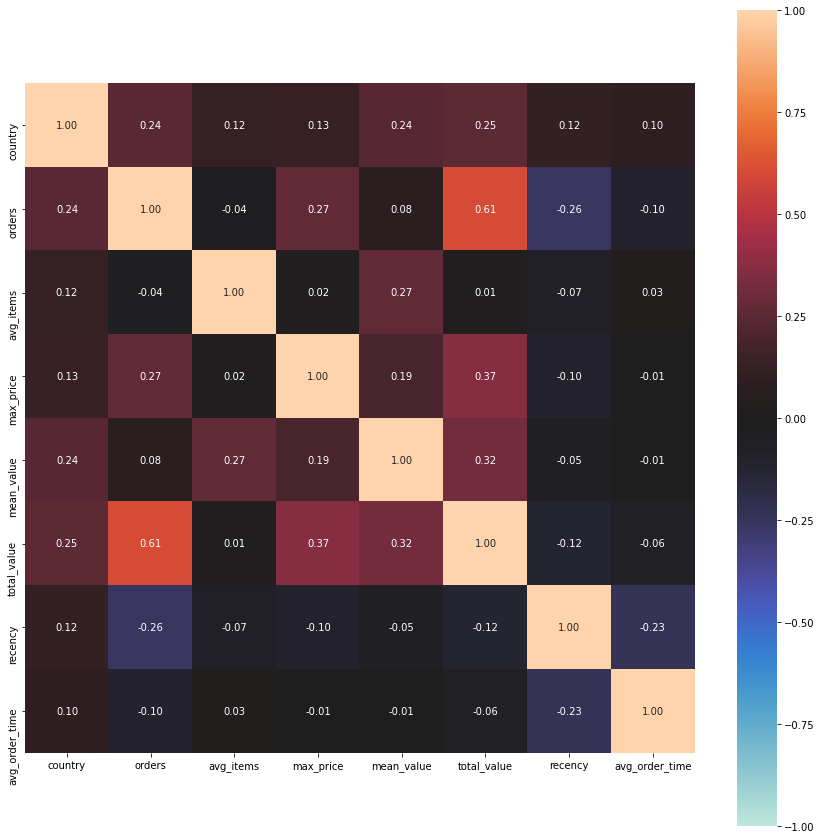

In [43]:
# Check correlations, including our nominal column, 'country'
nom_cols = ['country']

heatmap, corr_df = nominal.associations(customers, nominal_columns=nom_cols, theil_u=True, figsize=(15, 15))

plt.show()

The correlation table looks pretty good, with no strong correlations that might indicate redundancy. The strongest correlation is between number of orders and total value - a relationship that makes sense, yet it should still be valuable to have both columns of data for our customer segmentation.

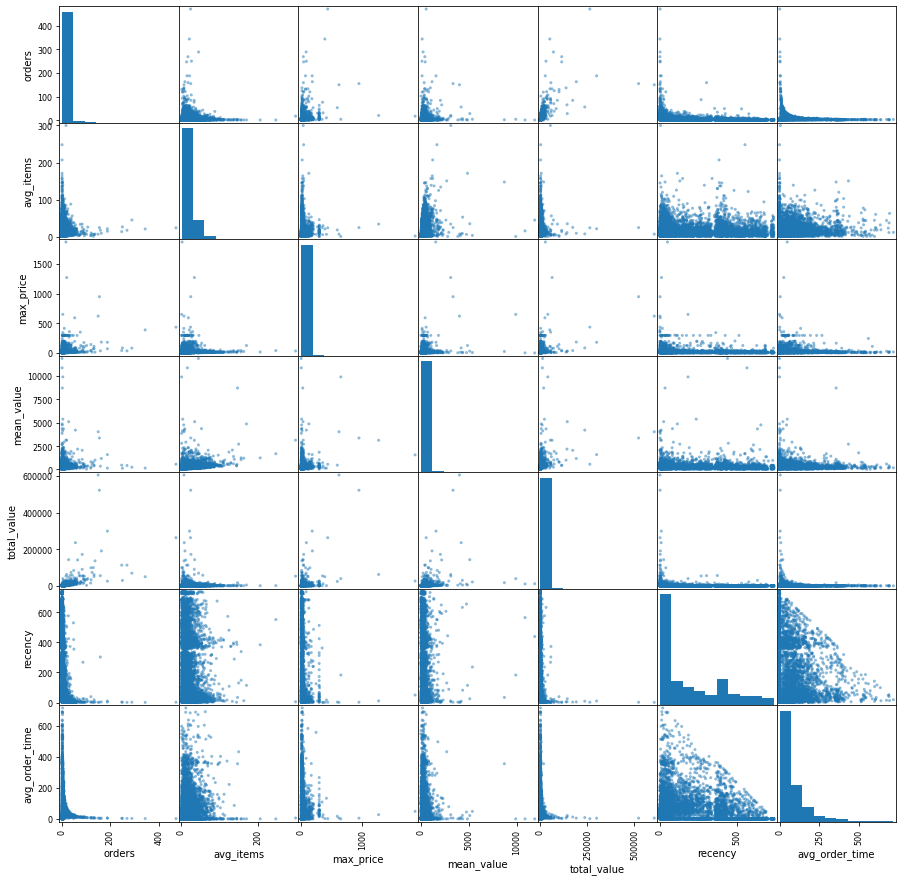

In [44]:
scatter_matrix(customers, figsize=(15, 15));

All of the columns have long right tails, with some extreme outliers changing the shape of the distributions. We can attempt to normalize the distributions by converting to a logarithmic scale - base 2 should work well. Note that our avg_order_time column contains 0s, so we need to add 1 to all the values before taking the log.

In [45]:
# create separate df with only numerical columns
log_customers = customers.drop(columns='country')

# Add 1 to avg_order_time
log_customers.avg_order_time = (log_customers.avg_order_time + 1)

In [46]:
# replace all values with log2 and check new quartiles
log_customers = np.log2(log_customers)
log_customers.describe()

,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,1.932849,3.815673,3.598121,7.879718,9.812568,6.335418,4.406934
std,1.557384,1.293144,1.234727,1.058126,1.998435,2.339200,3.003299
min,0.000000,0.000000,-2.556393,-0.048910,1.536053,0.000000,0.000000
25%,1.000000,3.115477,3.087463,7.279564,8.398701,4.643856,0.000000
50%,2.000000,3.906891,3.672425,7.876503,9.756840,6.539159,5.554589
75%,3.000000,4.643856,4.083213,8.488399,11.124050,8.558421,6.681871
max,8.879583,8.227404,10.867171,13.536349,19.206611,9.529431,9.481799


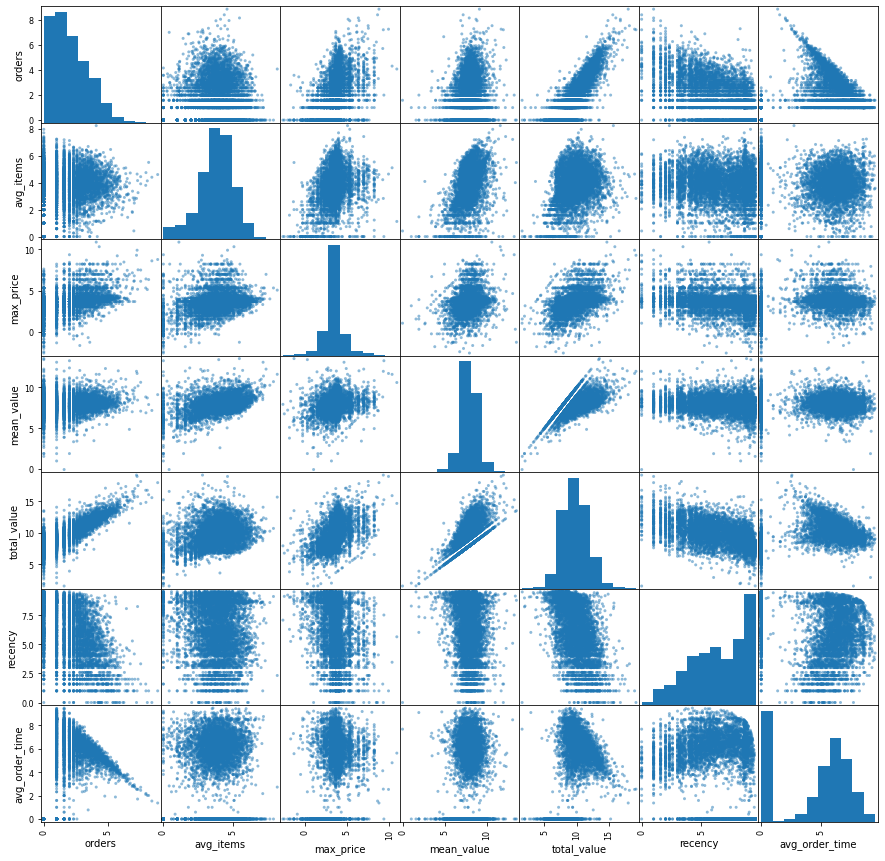

In [47]:
# Look at new distributions
scatter_matrix(log_customers, figsize=(15, 15));

These new distributions look closer to normal!

Finally, before we begin modelling we will have to encode our country column with dummy variables. With 41 different countries in the data (most of which have very few instances), it doesn't make sense to create a dummy variable for every value. Yet, country could be a valuable characteristic. Let's compromise by separating the countries into a few regions.

The vast majority of customers are in the UK (5320 of 5841), and the majority of the remaining 521 customers are in Europe. We can group all other continents together, as the data we have is probably not sufficient to say for sure whether there are actionable segment characteristics for smaller regions within the rest of the world.

In [48]:
# Create a mapping dictionary for our 3 regions: UK, Europe, and Other
assign_region = {}
for c in customers.country.value_counts().index:
    if c == 'United Kingdom':
        assign_region[c]='UK'
    elif c in ['Germany', 'France', 'Spain', 'Belgium', 'Portugal', 'Netherlands', 'Switzerland', 
               'Sweden', 'Italy', 'Finland', 'Austria', 'Channel Islands', 'Norway', 'Cyprus', 'Denmark',
               'Poland', 'Greece', 'EIRE', 'Malta', 'European Community', 'Iceland', 'Lithuania', 'Czech Republic']:
        assign_region[c]='Europe'
    else:
        assign_region[c]='Other'


In [49]:
# Map country column to a new region column
log_customers['region'] = customers.country.map(assign_region)
log_customers.region.value_counts()

UK        5320
Europe     459
Other       62
Name: region, dtype: int64

In [50]:
# get dummy columns to encode region category 
log_customers = pd.get_dummies(log_customers)

log_customers.head()

,orders,avg_items,max_price,mean_value,total_value,recency,avg_order_time,region_Europe,region_Other,region_UK
CustomerID,,,,,,,,,,
12346.0,2.584963,2.222392,6.693487,3.434295,6.019257,8.348728,7.335390,0,0,1
12347.0,3.000000,4.982994,3.672425,9.459770,12.459770,1.584963,5.857981,1,0,0
12348.0,2.321928,3.201634,0.536053,8.373648,10.695576,6.247928,6.515700,1,0,0
12349.0,2.000000,5.467606,5.320124,9.835474,11.835474,4.247928,8.159871,1,0,0
12350.0,0.000000,4.000000,1.560715,8.201634,8.201634,8.280771,0.000000,1,0,0


In the next notebook, we'll try a few different clustering models to identify meaningful customer segments.

In [51]:
# Let's save all of our DataFrames as .csv in the working directory
log_customers.to_csv('log_customers.csv')
customers.to_csv('customers.csv')
orders.to_csv('orders.csv')